In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from random import randint
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


The purpose of this notebook is to demonstrate the performance of the final classification and localization models. I will give a quick overview of what the data looks like, make predictions on our dataset, and explore the outputs of the hidden layers. 

For a quick summary of these models, the classification model had an accuracy of 90.3% and 89.6% in the validation and test sets, respectively; as well as F1 scores of 91.5% and 91.4%. The localization model was able to find the X, Y coordinates with a mean absolute error of ~2.5 pixels and the diameter within ~2.4 pixels on average between the two datasets. For a more indepth model evaluation, please see the 'Model evaluation' notebook in the Github repo!

In [0]:
test_labels = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/candidates_test.csv')
test_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Test/'

In [0]:
loc_model = load_model('/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/localization_0.2_dropout2.hdf5')
class_model = load_model('/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/classification_with_DA.hdf5')

We need to create two dataframes, one for our classification task, and one for our localization task.

In [0]:
test_list = []
for i in os.listdir(test_path):
  if i.startswith('pos'): test_list.append(i)
    
test_loc_df = pd.DataFrame({'x_col': test_list})
test_class_df = pd.DataFrame({'x_col': os.listdir(test_path)})

In [0]:
for i,img in enumerate(test_loc_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      test_loc_df.loc[i, 'voxel_x'] = test_labels.loc[img_id, 'voxel_x']
      test_loc_df.loc[i, 'voxel_y'] = test_labels.loc[img_id, 'voxel_y']
      test_loc_df.loc[i, 'diameter'] = test_labels.loc[img_id, 'voxel_d2']

      
for i,img in enumerate(test_class_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      test_class_df.loc[i, 'nodule'] = 'yes'

    else:
      test_class_df.loc[i, 'nodule'] ='no'

In [10]:
test_loc_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_loc_df,
                                                                     x_col='x_col',
                                                                     y_col=['voxel_x','voxel_y','diameter'],
                                                                     directory=test_path,
                                                                     target_size=(65,65),
                                                                     class_mode='raw',
                                                                     shuffle=False,
                                                                     batch_size=102)
test_class_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_class_df,
                                                                     x_col='x_col',
                                                                     y_col='nodule',
                                                                     directory=test_path,
                                                                     target_size=(65,65),
                                                                     class_mode='binary',
                                                                     shuffle=False,
                                                                     batch_size=173)

Found 102 validated image filenames.
Found 173 validated image filenames belonging to 2 classes.


Let's plot some of our images to get an idea of what we are working with.

In [0]:
imgs1, labels1 = test_class_batches[0]

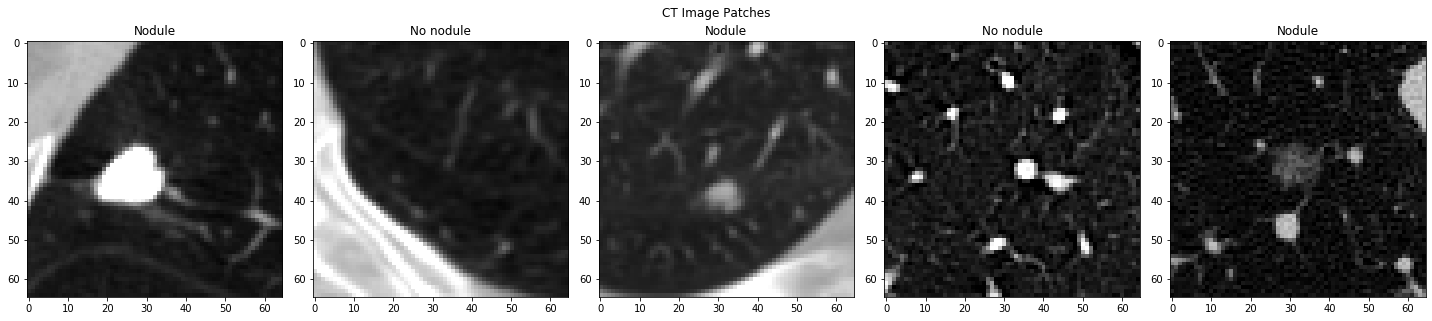

In [71]:
plt.figure(figsize=(20,5))
plt.suptitle('CT Image Patches', y=0.95)

index = [0, 160, 50, 130, 30]

for i, ind in enumerate(index):
  plt.subplot(1,5,i+1)
  plt.imshow(imgs1[ind])
  plt.title(np.where(labels1[ind]==1, 'Nodule', 'No nodule'))

plt.tight_layout()  
plt.show()

As you can see, identifying lung nodules in the images above is not an easy task (at least not for me) We can also visualize the nodule locations identified by the medical professionals who labeled this dataset.

In [0]:
imgs2, labels2 = test_loc_batches[0]

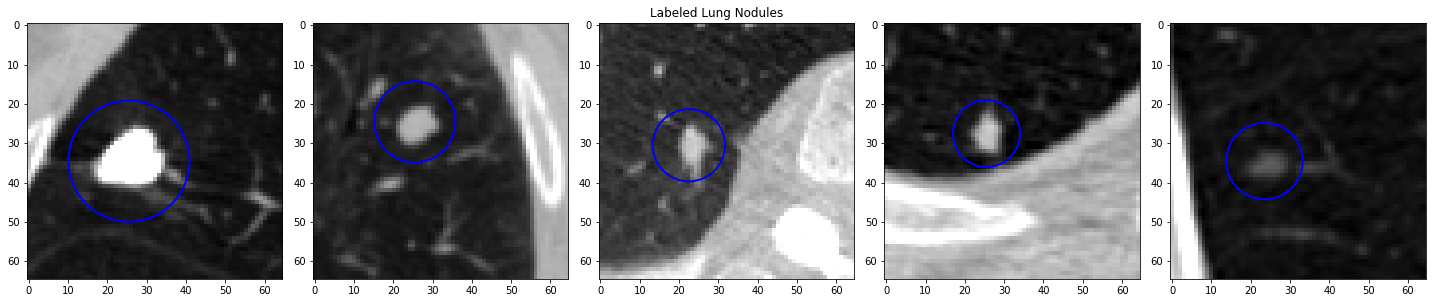

In [72]:
plt.figure(figsize=(20,5))
plt.suptitle('Labeled Lung Nodules', y=0.9)

for i in range(5):
  ax = plt.subplot(1,5,i+1)
  
  plt.imshow(imgs2[i])
  
  # Create circle patch for each labeled nodule
  circ = Circle((labels2[i,0], labels2[i,1]), 
                labels2[i, 2], 
                fill=False, 
                linestyle='-', 
                linewidth=2,
                color='b')
  ax.add_patch(circ)
  
plt.tight_layout()
plt.show()

Let's see how the model does making predictions on this data. We will start off with our classification model.

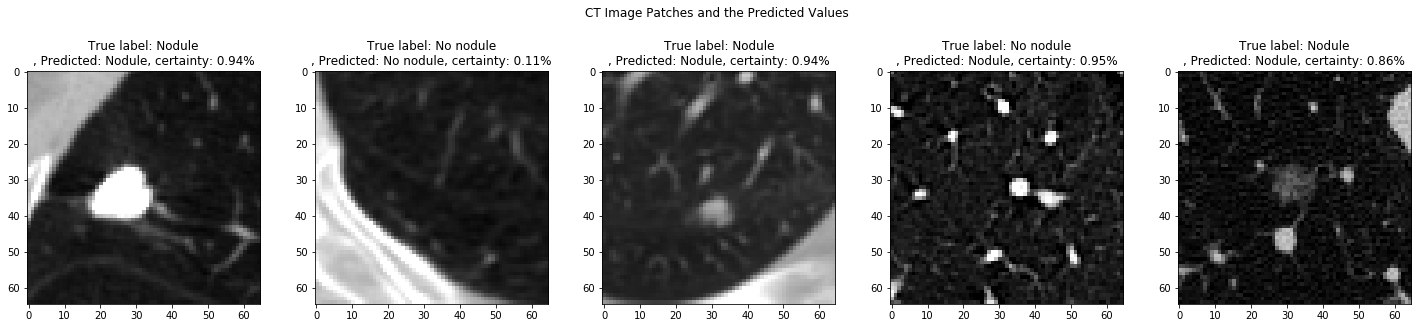

In [90]:
class_preds = class_model.predict(test_class_batches)

plt.figure(figsize=(20,5))
plt.suptitle('CT Image Patches and the Predicted Values', y=1)

# Standardized image indexes for consistency

index = [0, 160, 50, 130, 30]

for i, ind in enumerate(index):
  plt.subplot(1,5,i+1)
  plt.imshow(imgs1[ind])
  
  label = np.where(labels1[ind]==1, 'Nodule', 'No nodule')
  pred = np.where(class_preds[ind]<0.5, 'No nodule', 'Nodule')
  certainty = class_preds[ind,0]
  
  plt.title(f'True label: {label}\n, Predicted: {pred[0]}, certainty: {certainty:.2f}%')

plt.tight_layout()  
plt.show()

We can see that the model makes accurate predictions in 4 out of the 5 images. In image 4, the model predicts a nodule with 95% certainty despite there actually not being a nodule in this image. Looking at the slice, it is understandable that this would be a difficult image to classify! Let's see how the localization model performs. 

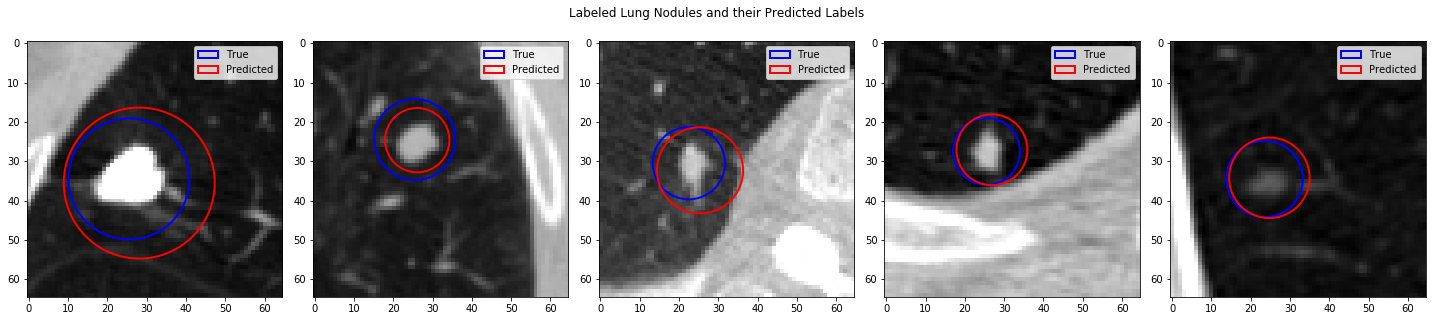

In [100]:
loc_preds = loc_model.predict(test_loc_batches)

plt.figure(figsize=(20,5))
plt.suptitle('Labeled Lung Nodules and their Predicted Labels', y=0.95)

for i in range(5):
  ax = plt.subplot(1,5,i+1)
  plt.imshow(imgs2[i])
  
  # Create circle patch for true labele
  circ1 = Circle((labels2[i,0], labels2[i,1]), 
                labels2[i, 2], 
                fill=False, 
                linestyle='-', 
                linewidth=2,
                color='b',)
  
  # Create circle path for predicted label
  circ2 = Circle((loc_preds[i,0], loc_preds[i,1]),
                 loc_preds[i,2],
                 fill=False, 
                 linestyle='-',
                 linewidth=2,
                 color='r',)
  
  ax.add_patch(circ1)
  ax.add_patch(circ2)
  plt.legend(['True','Predicted'],loc='upper right')
  
plt.tight_layout()
plt.show()

There is a significant amount of overlap between the predicted nodule masks and the mask given by the medical professionals! It is interesting to see the variation between these masks. This may be attributed to the three-dimentional nature of the nodules. The model makes predictions across two-dimensional horizontal (transverse) slices of CT scans. However, the medical team will likely label the diameter of these nodules using all three-dimensions.

Finally, let's explore the architecture of the models and explore the outputs of the hidden layers. Like above, I will start with the classification model and then move to the localization model.

In [102]:
class_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [0]:
# We need to add a dimension to simulate batched data
img = np.expand_dims(imgs1[0], axis=0)

# We will create 3 Keras functions, 1 per convolutional layer, probably not the most efficient way to do this but it works!

get_layer_output1 = K.function([class_model.layers[0].input],
                                  [class_model.layers[0].output])
get_layer_output2 = K.function([class_model.layers[0].input],
                                  [class_model.layers[2].output])
get_layer_output3 = K.function([class_model.layers[0].input],
                                  [class_model.layers[3].output])


layer_output1 = get_layer_output1([img])[0]
layer_output2 = get_layer_output2([img])[0]
layer_output3 = get_layer_output3([img])[0]

Now creating plots of these outputs is going to be tricky as there are 32 filter layers in each convolutional layer, meaning that our output is a 3d space that will always have a depth of 32. We can get an idea of what is going on by plotting 5 filter layers from each convolutional layer.

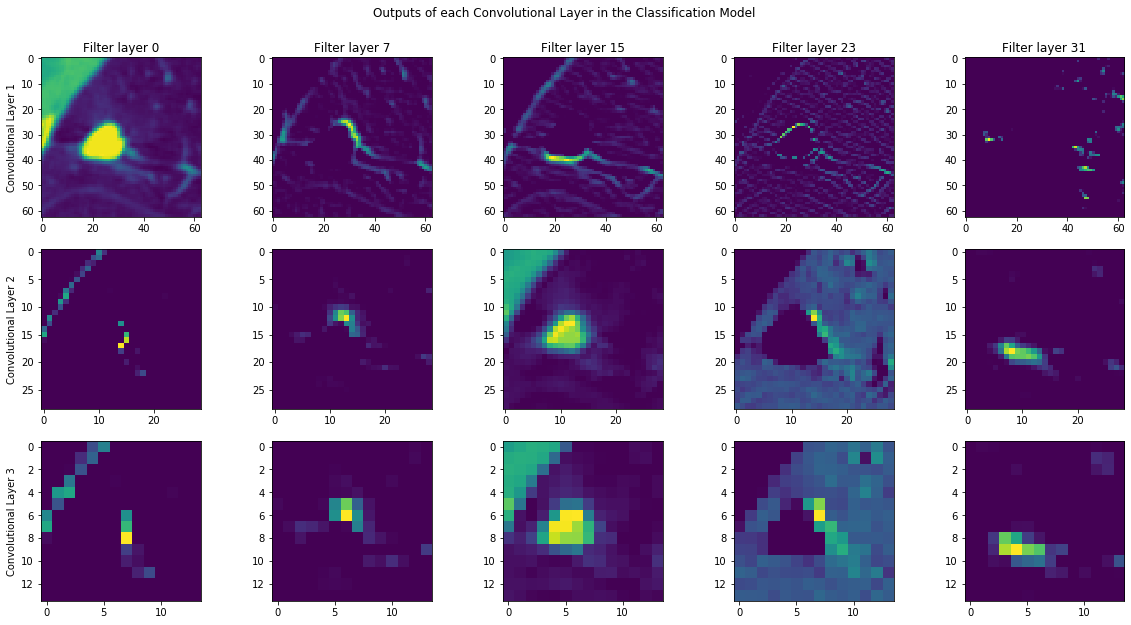

In [168]:
plt.figure(figsize=(20,10))
plt.suptitle('Outputs of each Convolutional Layer in the Classification Model', y=0.95)

count = 1
for l, layer in enumerate([layer_output1, layer_output2, layer_output3]):
  for i in [0,7,15,23,31]:
    ax = plt.subplot(3,5,count)
    
    if i == 0:
      ax.set_ylabel(f'Convolutional Layer {l+1}')
      
    if l == 0:
      plt.title(f'Filter layer {i}')
    
    plt.imshow(layer[0,:,:,i])
    count = count + 1

plt.show()

We can see that the model is reducing the nodule into small explicit points. This would seem useful for a binary classification task. Let's do the same with our localization model and see if the model outputs vary.

In [0]:
# We will create 3 Keras functions, 1 per convolutional layer, probably not the most efficient way to do this but it works!

get_layer_output1 = K.function([loc_model.layers[0].input],
                                  [loc_model.layers[0].output])
get_layer_output2 = K.function([loc_model.layers[0].input],
                                  [loc_model.layers[2].output])
get_layer_output3 = K.function([loc_model.layers[0].input],
                                  [loc_model.layers[3].output])


layer_output1 = get_layer_output1([img])[0]
layer_output2 = get_layer_output2([img])[0]
layer_output3 = get_layer_output3([img])[0]

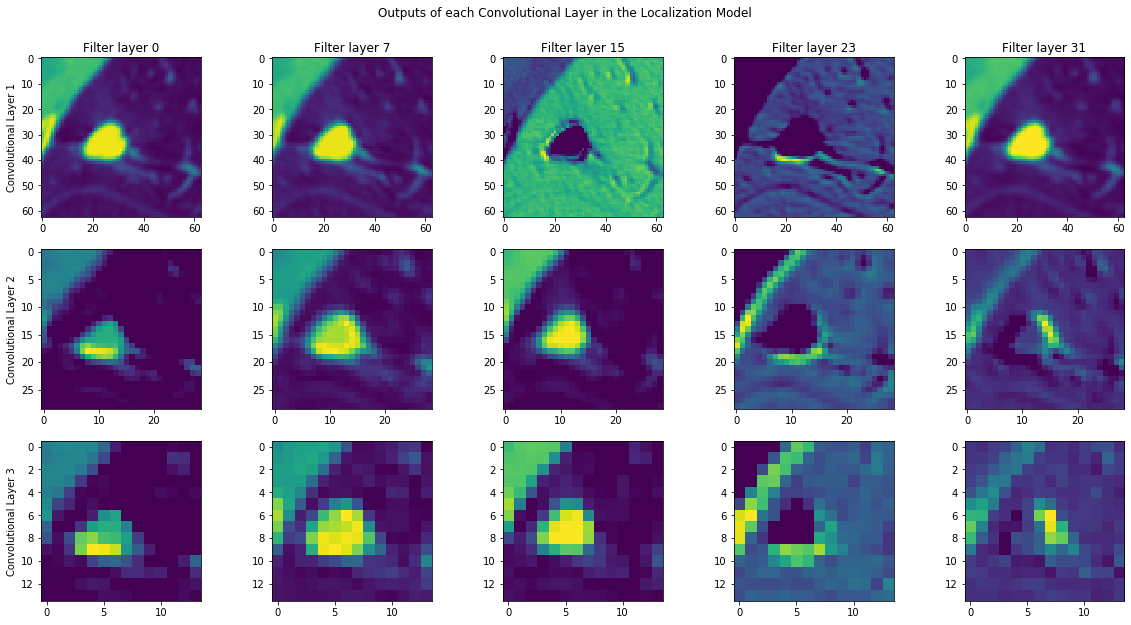

In [171]:
plt.figure(figsize=(20,10))
plt.suptitle('Outputs of each Convolutional Layer in the Localization Model', y=0.95)

count = 1
for l, layer in enumerate([layer_output1, layer_output2, layer_output3]):
  for i in [0,7,15,23,31]:
    ax = plt.subplot(3,5,count)
    
    if i == 0:
      ax.set_ylabel(f'Convolutional Layer {l+1}')
      
    if l == 0:
      plt.title(f'Filter layer {i}')
    
    plt.imshow(layer[0,:,:,i])
    count = count + 1

plt.show()

As one would suspect, it appears the localization model preserves the shape and location of the nodule much more explicitly than the classification model. This would be useful for finding the center coordinates and diameter of the nodules!